# Molecular cliffs analysis

Test the usage of Jointformer embeddings on bioactivity prediction task considering bioactivity cliffs.

This notebook utilizes MoleculeACE package: https://github.com/molML/MoleculeACE.

In [1]:
import copy
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from MoleculeACE import Data, Descriptors, get_benchmark_config, calc_rmse, calc_cliff_rmse
from MoleculeACE import SVM as MoleculeACE_SVM
from MoleculeACE import KNN as MoleculeACE_KNN

from jointformer.configs.dataset import DatasetConfig
from jointformer.configs.tokenizer import TokenizerConfig
from jointformer.utils.datasets.auto import AutoDataset
from jointformer.utils.tokenizers.auto import AutoTokenizer
from jointformer.configs.model import ModelConfig
from jointformer.models.auto import AutoModel
from jointformer.utils.properties.smiles.physchem import PhysChem

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-12 07:25:17.644901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 07:25:17.673640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 07:25:17.682142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 07:25:17.704082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to 

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
# !pip install tensorflow

## Utils

In [3]:
def compute_embeddings(inputs, model, embedding_func, tokenizer, batch_size=32, **tokenizer_call_kwargs):
    """Compute embeddings in batches."""
    embeddings = []
    for i in range(0, len(inputs), batch_size):
        inputs_batch = tokenizer(inputs[i:i + batch_size], **tokenizer_call_kwargs)
        embeddings_batch = embedding_func(model, inputs_batch).detach()
        embeddings.append(embeddings_batch)
    return torch.cat(embeddings)

def evaluate_regression(y_true, y_pred):
    """Evaluate regression predictions."""
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    pearson = pearsonr(y_true, y_pred)[0]
    spearman = spearmanr(y_true, y_pred)[0]
    return {
        "rmse": rmse,
        "pearson": pearson,
        "spearman": spearman,
    }

## Load MoleculeACE datasets info


In [4]:
# Load all datasets from the MoleculeACE package
datasets_list_df = pd.read_csv('https://github.com/molML/MoleculeACE/blob/main/MoleculeACE/Data/benchmark_data/metadata/datasets.csv?raw=true')

print(datasets_list_df.shape)
datasets_list_df.head()

(30, 15)


,Dataset,ChEMBL ID,Target name,Abbriviation,Type,Receptor Class,Compounds,Cliff compounds,Percentage cliffs,Train compounds,Train cliff compounds,Percentage train cliffs,Test compounds,Test cliff compounds,Percentage test cliffs
0,CHEMBL1871_Ki,CHEMBL1871,Androgen Receptor,AR,Ki,NR,659,157,24,525,126,24,134,31,23
1,CHEMBL218_EC50,CHEMBL218,Cannabinoid receptor 1,CB1,EC50,GPCR,1031,367,36,823,292,35,208,75,36
2,CHEMBL244_Ki,CHEMBL244,Coagulation factor X,FX,Ki,Protease,3097,1350,44,2476,1080,44,621,270,43
3,CHEMBL236_Ki,CHEMBL236,Delta opioid receptor,DOR,Ki,GPCR,2598,965,37,2077,772,37,521,193,37
4,CHEMBL234_Ki,CHEMBL234,Dopamine D3 receptor,D3R,Ki,GPCR,3657,1441,39,2923,1150,39,734,291,40


## Multiple datasets modeling

### Setup Jointformer

In [15]:
model_config_dict = {
        "path_to_tokenizer": '../../../../checkpoints/jointformer/separate_task_token/configs/tokenizers/smiles_separate_task_token',
        "path_to_model_config": '../../../../checkpoints/jointformer/separate_task_token/configs/models/jointformer_separate_task_token',
        "path_to_vocab": "../../data/vocabularies/deepchem.txt",
        "path_to_model_checkpoint": "../../../../checkpoints/jointformer/separate_task_token/ckpt.pt"
    }

# Get tokenizer
tokenizer_config = TokenizerConfig.from_config_file(model_config_dict["path_to_tokenizer"])
tokenizer_config.path_to_vocabulary = model_configs_dict["path_to_vocab"]
tokenizer = AutoTokenizer.from_config(tokenizer_config)

model_config = ModelConfig.from_config_file(model_config_dict["path_to_model_config"])
jointformer = AutoModel.from_config(model_config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model checkpoint on cpu
jointformer.eval()
jointformer.to(device)    

jointformer.load_pretrained(model_config_dict["path_to_model_checkpoint"])

smiles_encoder = jointformer.to_smiles_encoder(tokenizer, batch_size=2, device="cpu")

In [16]:
# # Get model
#     model_config = ModelConfig.from_config_file(model_configs_dict[model_alias]["path_to_model_config"])
#     model = AutoModel.from_config(model_config)
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'

#     # Load model checkpoint on cpu
#     model.eval()
#     model.to(device)    

#     if model_alias != "ChemBERTa":
#         try:
#             model.load_pretrained(model_configs_dict[model_alias]["path_to_model_checkpoint"])
#         except RuntimeError:
#             model.load_pretrained(model_configs_dict[model_alias]["path_to_model_checkpoint"], map_location='cpu')

#     # Get embeddings
#     print(f"Computing embeddings for model {model_alias}...")

#     smiles_encoder = model.to_smiles_encoder(tokenizer, batch_size=2, device="cpu")
#     embeddings = smiles_encoder.encode(molecules_list)

### Iterate over datasets and compare ML models with Jointformer embeddings with best model and representations from paper

In [17]:
# Define hparams grid for traditional ML models - same grids as in MoleculeACE paper
per_model_hyperparameters_grid = {
    "knn": {
        "n_neighbors": [1, 3, 11, 21],
        "metric": ["cosine", "euclidean"]
    },
    "svm": {
        "C": [1, 10, 100, 1000, 10000],
        "gamma": [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
    }
}

In [22]:
# Initialize results 
results = {
    "dataset": [],
    "model": [],
    "test_rmse": [],
    "test_cliff_rmse": [],
}

# Iterate over all datasets
for dataset in datasets_list_df["Dataset"].unique():
    # Load data
    raw_data = Data(dataset)

    # Compute embeddings
    X_train_jointformer_embeddings = smiles_encoder.encode(raw_data.smiles_train)

    X_test_jointformer_embeddings = smiles_encoder.encode(raw_data.smiles_test)

    ### Model with svm and jointformer embeddings
    model = SVR(kernel="rbf")

    # Grid search
    grid_search = GridSearchCV(model, per_model_hyperparameters_grid["svm"], scoring="neg_mean_squared_error", n_jobs=2, cv=5)
    grid_search.fit(X_train_jointformer_embeddings, raw_data.y_train)

    # Evaluate
    y_pred = grid_search.best_estimator_.predict(X_test_jointformer_embeddings)
    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("svm_jointformer")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    ### Model with knn and jointformer embeddings
    model = KNeighborsRegressor()

    # Grid search
    grid_search = GridSearchCV(model, per_model_hyperparameters_grid["knn"], scoring="neg_mean_squared_error", n_jobs=2, cv=5)
    grid_search.fit(X_train_jointformer_embeddings, raw_data.y_train)

    # Evaluate
    y_pred = grid_search.best_estimator_.predict(X_test_jointformer_embeddings)
    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("knn_jointformer")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    ### Model from the MoleculeACE package - SVM with ECFP fingerprints
    algorithm = MoleculeACE_SVM
    
    # Get a featurizer
    descriptor = Descriptors.ECFP
    # Featurize the data
    raw_data(descriptor)

    # Get the already optimized hyperparameters
    hyperparameters = get_benchmark_config(dataset, algorithm, descriptor)

    # Train and evaluate
    model = algorithm(**hyperparameters)
    model.train(raw_data.x_train, raw_data.y_train)
    y_pred = model.predict(raw_data.x_test)

    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("svm_ecfp")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    ### Model from the MoleculeACE package - KNN with ECFP fingerprints
    algorithm = MoleculeACE_KNN
    
    # Get a featurizer
    descriptor = Descriptors.ECFP
    # Featurize the data
    raw_data(descriptor)

    # Get the already optimized hyperparameters
    hyperparameters = get_benchmark_config(dataset, algorithm, descriptor)

    # Train and evaluate
    model = algorithm(**hyperparameters)
    model.train(raw_data.x_train, raw_data.y_train)
    y_pred = model.predict(raw_data.x_test)

    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("knn_ecfp")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

results_df = pd.DataFrame(results)

Encoding samples:   0%|          | 1/263 [00:00<00:40,  6.51it/s]

Encoding samples:  83%|████████▎ | 217/263 [00:12<00:02, 18.14it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Encoding samples:  83%|██████

KeyboardInterrupt: 

## Display the results

In [7]:
print(results_df.shape)

results_df.head()

(120, 4)


,dataset,model,test_rmse,test_cliff_rmse
0,CHEMBL1871_Ki,svm_jointformer,0.812010,1.036033
1,CHEMBL1871_Ki,knn_jointformer,0.847621,1.165791
2,CHEMBL1871_Ki,svm_ecfp,0.664931,0.873356
3,CHEMBL1871_Ki,knn_ecfp,0.649790,0.817006
4,CHEMBL218_EC50,svm_jointformer,0.761406,0.819545


In [8]:
# Aggregate results over models
results_agg_df = results_df.groupby("model").agg({
    "test_rmse": ["mean", "std"],
    "test_cliff_rmse": ["mean", "std"],
})
results_agg_df

test_rmse           test_cliff_rmse          
                     mean       std            mean       std
model                                                        
knn_ecfp         0.728975  0.095928        0.838777  0.093639
knn_jointformer  0.884553  0.122473        0.928047  0.123543
svm_ecfp         0.671198  0.079625        0.751129  0.095433
svm_jointformer  0.784181  0.110780        0.864499  0.114079

/tmp/ipykernel_117032/753014347.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="model", y="test_rmse", ax=ax[0], palette=p)
/tmp/ipykernel_117032/753014347.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="model", y="test_cliff_rmse", ax=ax[1], palette=p)


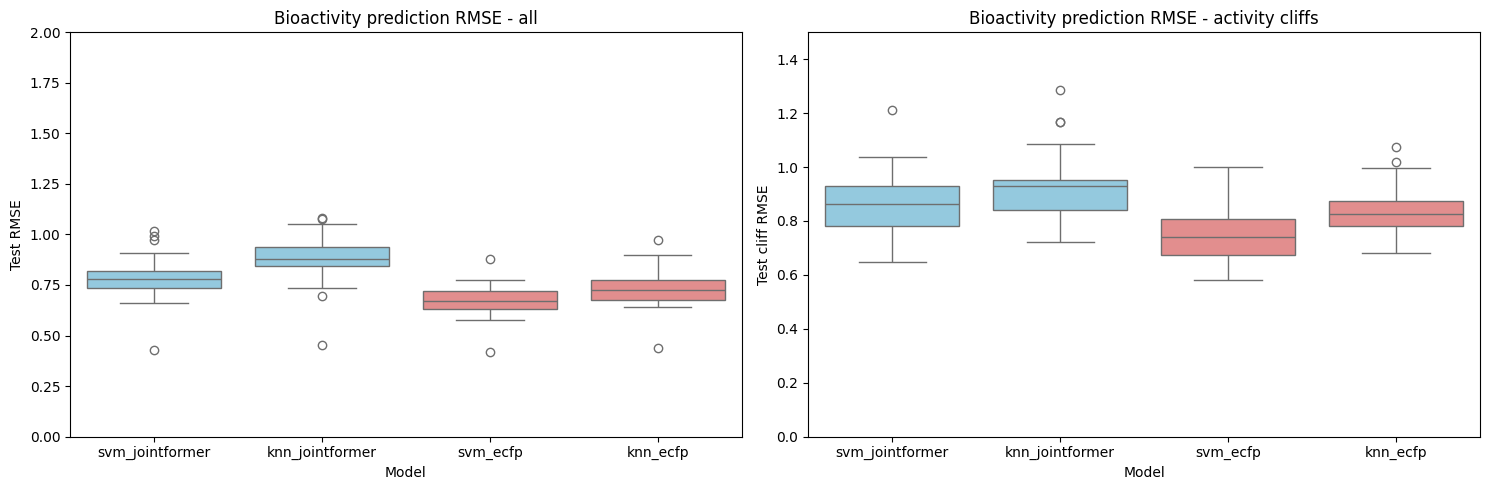

In [14]:
# Boxplot of the results
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Define your custom palette
p = {
    "svm_jointformer": "skyblue",
    "knn_jointformer": "skyblue",
    "svm_ecfp": "lightcoral",
    "knn_ecfp": "lightcoral",

}

sns.boxplot(data=results_df, x="model", y="test_rmse", ax=ax[0], palette=p)
ax[0].set_title("Bioactivity prediction RMSE - all")
ax[0].set_ylabel("Test RMSE")
ax[0].set_xlabel("Model")
# Same scale on y-axis
ax[0].set_ylim(0, 2)

sns.boxplot(data=results_df, x="model", y="test_cliff_rmse", ax=ax[1], palette=p)
ax[1].set_title("Bioactivity prediction RMSE - activity cliffs")
ax[1].set_ylabel("Test cliff RMSE")
ax[1].set_xlabel("Model")
# Same scale on y-axis
ax[1].set_ylim(0, 1.5)

plt.tight_layout()
plt.show()

## Results for every model

In [5]:
# Parameters

model_configs_dict = {
    # "Unimol": {
    #     "path_to_tokenizer": None,
    #     "path_to_model_config": '../../configs/models/unimol',
    #     "path_to_model_checkpoint": "../../../../checkpoints/unimol/ckpt.pt"
    # },

    "Jointformer": {
        "path_to_tokenizer": '../../../../checkpoints/jointformer/separate_task_token/configs/tokenizers/smiles_separate_task_token',
        "path_to_model_config": '../../../../checkpoints/jointformer/separate_task_token/configs/models/jointformer_separate_task_token',
        "path_to_vocab": "../../data/vocabularies/deepchem.txt",
        "path_to_model_checkpoint": "../../../../checkpoints/jointformer/separate_task_token/ckpt.pt"
    },

    "ChemBERTa": {
        "path_to_tokenizer": "../../configs/tokenizers/chemberta",
        "path_to_model_config": '../../configs/models/chemberta_for_regression',
        "path_to_model_checkpoint": "DeepChem/ChemBERTa-77M-MTR"
    },

    "MolGPT": {
        "path_to_tokenizer": None,
        "path_to_model_config": '../../configs/models/molgpt',
        "path_to_model_checkpoint": "../../../../checkpoints/molgpt/ckpt.pt"

    },

    "MoLeR": {
        "path_to_tokenizer": None,
        "path_to_model_config": '../../configs/models/moler',
        "path_to_model_checkpoint": "../../../../checkpoints/moler/ckpt.pkl"
    },
    
    # "RegressionTransformer": {
    #     "path_to_tokenizer": None,
    #     "path_to_model_config": '../../configs/models/regression_transformer',
    #     "path_to_model_checkpoint": "../../../../checkpoints/regression_transformer/logp_synthesizability/logp_and_synthesizability/pytorch_model.bin"
    # }

}

In [6]:
# Define hparams grid for traditional ML models - same grids as in MoleculeACE paper
per_model_hyperparameters_grid = {
    "knn": {
        "n_neighbors": [1, 3, 11, 21],
        "metric": ["cosine", "euclidean"]
    },
    "svm": {
        "C": [1, 10, 100, 1000, 10000],
        "gamma": [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
    }
}

In [7]:
# Initialize results 
results = {
    "dataset": [],
    "model": [],
    "test_rmse": [],
    "test_cliff_rmse": [],
}

for model_alias in model_configs_dict.keys():
    print(f"Loading model {model_alias}...")
    
    # Get tokenizer if needed
    if model_configs_dict[model_alias]["path_to_tokenizer"] is not None:
        tokenizer_config = TokenizerConfig.from_config_file(model_configs_dict[model_alias]["path_to_tokenizer"])
        if model_alias == "Jointformer":
            tokenizer_config.path_to_vocabulary = model_configs_dict[model_alias]["path_to_vocab"]
        tokenizer = AutoTokenizer.from_config(tokenizer_config)
    else:
        tokenizer = None
    
    # Get model
    model_config = ModelConfig.from_config_file(model_configs_dict[model_alias]["path_to_model_config"])
    smiles_model = AutoModel.from_config(model_config)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load model checkpoint on cpu
    smiles_model.eval()
    smiles_model.to(device)    

    if model_alias != "ChemBERTa":
        try:
            smiles_model.load_pretrained(model_configs_dict[model_alias]["path_to_model_checkpoint"])
        except RuntimeError:
            smiles_model.load_pretrained(model_configs_dict[model_alias]["path_to_model_checkpoint"], map_location='cpu')

    # Get embeddings
    print(f"Computing embeddings for model {model_alias}...")

    smiles_encoder = smiles_model.to_smiles_encoder(tokenizer, batch_size=2, device="cpu")

    # Iterate over all datasets
    for dataset in datasets_list_df["Dataset"].unique()[:10]:
        # Load data
        raw_data = Data(dataset)

        # Compute embeddings
        X_train_jointformer_embeddings = smiles_encoder.encode(raw_data.smiles_train)

        X_test_jointformer_embeddings = smiles_encoder.encode(raw_data.smiles_test)

        ### Model with svm and jointformer embeddings
        model = SVR(kernel="rbf")

        # Grid search
        grid_search = GridSearchCV(model, per_model_hyperparameters_grid["svm"], scoring="neg_mean_squared_error", n_jobs=2, cv=5)
        grid_search.fit(X_train_jointformer_embeddings, raw_data.y_train)

        # Evaluate
        y_pred = grid_search.best_estimator_.predict(X_test_jointformer_embeddings)
        test_rmse = calc_rmse(raw_data.y_test, y_pred)
        test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

        results["dataset"].append(dataset)
        results["model"].append(f"svm_{model_alias}")
        results["test_rmse"].append(test_rmse)
        results["test_cliff_rmse"].append(test_cliff_rmse)

        ### Model with knn and jointformer embeddings
        model = KNeighborsRegressor()

        # Grid search
        grid_search = GridSearchCV(model, per_model_hyperparameters_grid["knn"], scoring="neg_mean_squared_error", n_jobs=2, cv=5)
        grid_search.fit(X_train_jointformer_embeddings, raw_data.y_train)

        # Evaluate
        y_pred = grid_search.best_estimator_.predict(X_test_jointformer_embeddings)
        test_rmse = calc_rmse(raw_data.y_test, y_pred)
        test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

        results["dataset"].append(dataset)
        results["model"].append(f"knn_{model_alias}")
        results["test_rmse"].append(test_rmse)
        results["test_cliff_rmse"].append(test_cliff_rmse)


# Iterate over all datasets
for dataset in datasets_list_df["Dataset"].unique()[:10]:
    ### Model from the MoleculeACE package - SVM with ECFP fingerprints
    algorithm = MoleculeACE_SVM

    # Get a featurizer
    descriptor = Descriptors.ECFP
    # Featurize the data
    raw_data(descriptor)

    # Get the already optimized hyperparameters
    hyperparameters = get_benchmark_config(dataset, algorithm, descriptor)

    # Train and evaluate
    model = algorithm(**hyperparameters)
    model.train(raw_data.x_train, raw_data.y_train)
    y_pred = model.predict(raw_data.x_test)

    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("svm_ecfp")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    ### Model from the MoleculeACE package - KNN with ECFP fingerprints
    algorithm = MoleculeACE_KNN

    # Get a featurizer
    descriptor = Descriptors.ECFP
    # Featurize the data
    raw_data(descriptor)

    # Get the already optimized hyperparameters
    hyperparameters = get_benchmark_config(dataset, algorithm, descriptor)

    # Train and evaluate
    model = algorithm(**hyperparameters)
    model.train(raw_data.x_train, raw_data.y_train)
    y_pred = model.predict(raw_data.x_test)

    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("knn_ecfp")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    results_df = pd.DataFrame(results)
    
    

Loading model Jointformer...
Computing embeddings for model Jointformer...


Encoding samples:  82%|████████▏ | 216/263 [00:15<00:03, 14.07it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Encoding samples:  83%|████████▎ | 218/263 [00:15<00:03, 13.13it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty e

Loading model ChemBERTa...


Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MTR were not used when initializing RobertaForRegression: ['norm_mean', 'norm_std']
- This IS expected if you are initializing RobertaForRegression from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForRegression from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForRegression were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized because the shapes did not match:
- regression.out_proj.weight: found shape torch.Size([199, 384]) in the checkpoint and torch.Size([1, 384]) in the model instantiated
- regression.out_proj.bias: found shape torch.Size([199]) in the check

Computing embeddings for model ChemBERTa...


Encoding samples: 100%|██████████| 70/70 [00:00<00:00, 89.82it/s]


Loading model MolGPT...


INFO: number of parameters: 6.392832e+06


Removed key: prop_nn.weight from checkpoint; not found in model or size mismatch.
Removed key: prop_nn.bias from checkpoint; not found in model or size mismatch.
Computing embeddings for model MolGPT...


  0%|          | 0/263 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

Loading model MoLeR...


ModuleNotFoundError: No module named 'tensorflow.python.training.tracking'

In [11]:
import copy
results_copy = copy.deepcopy(results)

In [12]:
# Iterate over all datasets
for dataset in datasets_list_df["Dataset"].unique()[:10]:
    ### Model from the MoleculeACE package - SVM with ECFP fingerprints
    algorithm = MoleculeACE_SVM

    # Get a featurizer
    descriptor = Descriptors.ECFP
    # Featurize the data
    raw_data(descriptor)

    # Get the already optimized hyperparameters
    hyperparameters = get_benchmark_config(dataset, algorithm, descriptor)

    # Train and evaluate
    model = algorithm(**hyperparameters)
    model.train(raw_data.x_train, raw_data.y_train)
    y_pred = model.predict(raw_data.x_test)

    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("svm_ecfp")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    ### Model from the MoleculeACE package - KNN with ECFP fingerprints
    algorithm = MoleculeACE_KNN

    # Get a featurizer
    descriptor = Descriptors.ECFP
    # Featurize the data
    raw_data(descriptor)

    # Get the already optimized hyperparameters
    hyperparameters = get_benchmark_config(dataset, algorithm, descriptor)

    # Train and evaluate
    model = algorithm(**hyperparameters)
    model.train(raw_data.x_train, raw_data.y_train)
    y_pred = model.predict(raw_data.x_test)

    test_rmse = calc_rmse(raw_data.y_test, y_pred)
    test_cliff_rmse = calc_cliff_rmse(y_test_pred=y_pred, y_test=raw_data.y_test, cliff_mols_test=raw_data.cliff_mols_test)

    results["dataset"].append(dataset)
    results["model"].append("knn_ecfp")
    results["test_rmse"].append(test_rmse)
    results["test_cliff_rmse"].append(test_cliff_rmse)

    results_df = pd.DataFrame(results)

In [15]:
# Save results
results_df.to_csv("cliffs_results.csv", index=False)

In [26]:
results_df[results_df["model"] == "svm_ecfp"]

,dataset,model,test_rmse,test_cliff_rmse
60,CHEMBL1871_Ki,svm_ecfp,0.635268,0.69243
62,CHEMBL218_EC50,svm_ecfp,0.635268,0.69243
64,CHEMBL244_Ki,svm_ecfp,0.635268,0.69243
66,CHEMBL236_Ki,svm_ecfp,0.635268,0.69243
68,CHEMBL234_Ki,svm_ecfp,0.635268,0.69243
70,CHEMBL219_Ki,svm_ecfp,0.635268,0.69243
72,CHEMBL238_Ki,svm_ecfp,0.635268,0.69243
74,CHEMBL4203_Ki,svm_ecfp,0.635268,0.69243
76,CHEMBL2047_EC50,svm_ecfp,0.635268,0.69243
78,CHEMBL4616_EC50,svm_ecfp,0.635268,0.69243


In [18]:
# Load results
results_df = pd.read_csv("cliffs_results.csv")

print(results_df.shape)
results_df.head()

(80, 4)


,dataset,model,test_rmse,test_cliff_rmse
0,CHEMBL1871_Ki,svm_Jointformer,0.751870,0.972532
1,CHEMBL1871_Ki,knn_Jointformer,0.782974,1.005236
2,CHEMBL218_EC50,svm_Jointformer,0.831831,0.873431
3,CHEMBL218_EC50,knn_Jointformer,0.933281,0.926280
4,CHEMBL244_Ki,svm_Jointformer,0.998222,1.004544


In [19]:
# Aggregate results over models
results_agg_df = results_df.groupby("model").agg({
    "test_rmse": ["mean", "std"],
    "test_cliff_rmse": ["mean", "std"],
})
results_agg_df

test_rmse           test_cliff_rmse          
                     mean       std            mean       std
model                                                        
knn_ChemBERTa    0.876673  0.102729        0.911365  0.137953
knn_Jointformer  0.942033  0.127061        0.943374  0.154292
knn_MolGPT       0.914833  0.088401        0.965634  0.146896
knn_ecfp         0.734557  0.002506        0.826023  0.000802
svm_ChemBERTa    0.814152  0.107163        0.902135  0.201192
svm_Jointformer  0.848662  0.104998        0.910169  0.162760
svm_MolGPT       0.790100  0.091727        0.873872  0.172224
svm_ecfp         0.635268  0.000000        0.692430  0.000000

In [25]:
# Sort by test cliff rmse
print(results_agg_df.sort_values(("test_cliff_rmse", "mean")).to_latex())
results_agg_df.sort_values(("test_cliff_rmse", "mean"))

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{test\_rmse} & \multicolumn{2}{l}{test\_cliff\_rmse} \\
{} &      mean &       std &            mean &       std \\
model           &           &           &                 &           \\
\midrule
svm\_ecfp        &  0.635268 &  0.000000 &        0.692430 &  0.000000 \\
knn\_ecfp        &  0.734557 &  0.002506 &        0.826023 &  0.000802 \\
svm\_MolGPT      &  0.790100 &  0.091727 &        0.873872 &  0.172224 \\
svm\_ChemBERTa   &  0.814152 &  0.107163 &        0.902135 &  0.201192 \\
svm\_Jointformer &  0.848662 &  0.104998 &        0.910169 &  0.162760 \\
knn\_ChemBERTa   &  0.876673 &  0.102729 &        0.911365 &  0.137953 \\
knn\_Jointformer &  0.942033 &  0.127061 &        0.943374 &  0.154292 \\
knn\_MolGPT      &  0.914833 &  0.088401 &        0.965634 &  0.146896 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_23794/4121289481.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_agg_df.sort_values(("test_cliff_rmse", "mean")).to_latex())


test_rmse           test_cliff_rmse          
                     mean       std            mean       std
model                                                        
svm_ecfp         0.635268  0.000000        0.692430  0.000000
knn_ecfp         0.734557  0.002506        0.826023  0.000802
svm_MolGPT       0.790100  0.091727        0.873872  0.172224
svm_ChemBERTa    0.814152  0.107163        0.902135  0.201192
svm_Jointformer  0.848662  0.104998        0.910169  0.162760
knn_ChemBERTa    0.876673  0.102729        0.911365  0.137953
knn_Jointformer  0.942033  0.127061        0.943374  0.154292
knn_MolGPT       0.914833  0.088401        0.965634  0.146896

/tmp/ipykernel_23794/3503739359.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_23794/3503739359.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


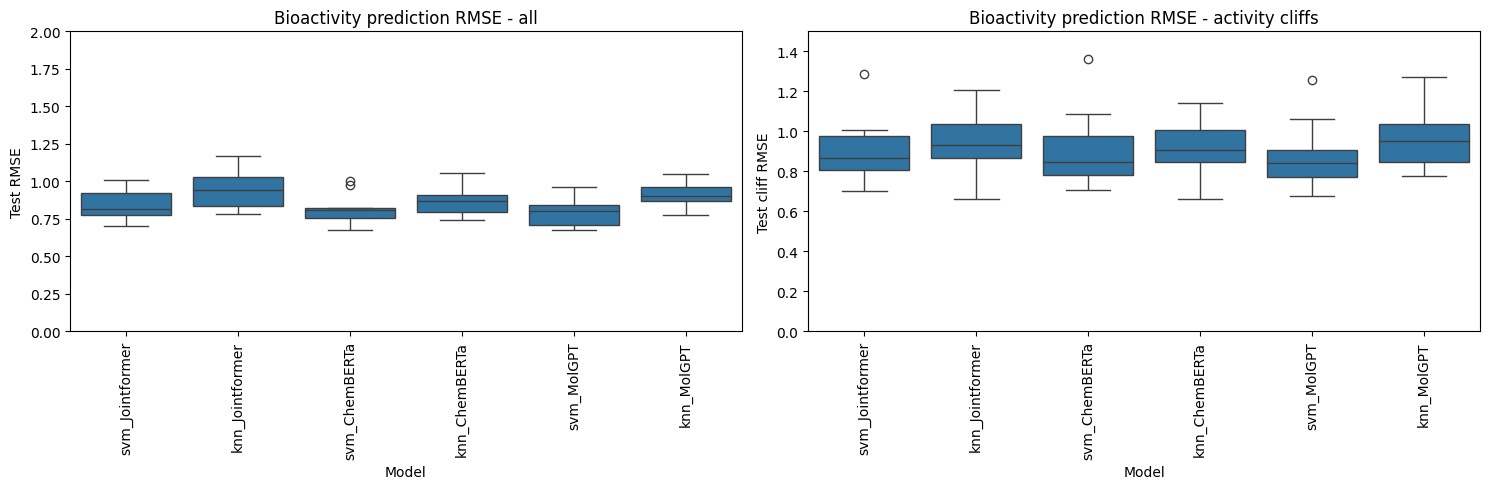

In [29]:
# Boxplot of the results
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Define your custom palette
# p = {
#     "svm_jointformer": "skyblue",
#     "knn_jointformer": "skyblue",
#     "svm_ecfp": "lightcoral",
#     "knn_ecfp": "lightcoral",

# }

sns.boxplot(data=results_df[~results_df["model"].str.contains("ecfp")], x="model", y="test_rmse", ax=ax[0])
ax[0].set_title("Bioactivity prediction RMSE - all")
ax[0].set_ylabel("Test RMSE")
ax[0].set_xlabel("Model")
# Same scale on y-axis
ax[0].set_ylim(0, 2)
# Rotate x-axis tick labels
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.boxplot(data=results_df[~results_df["model"].str.contains("ecfp")], x="model", y="test_cliff_rmse", ax=ax[1])
ax[1].set_title("Bioactivity prediction RMSE - activity cliffs")
ax[1].set_ylabel("Test cliff RMSE")
ax[1].set_xlabel("Model")
# Same scale on y-axis
ax[1].set_ylim(0, 1.5)
# Rotate x-axis tick labels
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.savefig("cliffs_results.pdf")
plt.show()